In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import fredapi 
#import yfinance as yf
import datetime
import seaborn as sns
import random
from statsmodels.tsa.seasonal import seasonal_decompose
import json

# ERad in the data using json from the BLC Public API

In [2]:
import requests
import json
headers = {'Content-type': 'application/json'}

all_json_data = []

for year in range (2000,2025,5):

    data = json.dumps({"seriesid": ['CUUR0000SA0'],"startyear":str(year), "endyear":str(year+5)})
    p = requests.post('https://api.bls.gov/publicAPI/v2/timeseries/data/', data=data, headers=headers)
    json_data = json.loads(p.text)
    all_json_data.append(json_data)

KeyboardInterrupt: 

In [33]:
with open ('all_json_data','w') as outfile:
    json.dump(all_json_data, outfile)

In [2]:
with open ('all_json_data','r') as openfile:
    all_json_data = json.load(openfile)

# Parse the json data into a dataframe

In [3]:
data_dict =dict()

for section in all_json_data:
    for part in section['Results']['series']:
        for item in part['data']:
            year = item['year']
            month = item['periodName']
            value = item['value']
            data_dict[month+' '+ year] = value
        
df = pd.DataFrame(data_dict.items(),columns = ['date','CPI'])
df['CPI'] = df['CPI'].astype(float)
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df.sort_index(inplace=True)
df.head()

,CPI
date,
2000-01-01,168.8
2000-02-01,169.8
2000-03-01,171.2
2000-04-01,171.3
2000-05-01,171.5


Text(0, 0.5, 'Consumer Price Index')

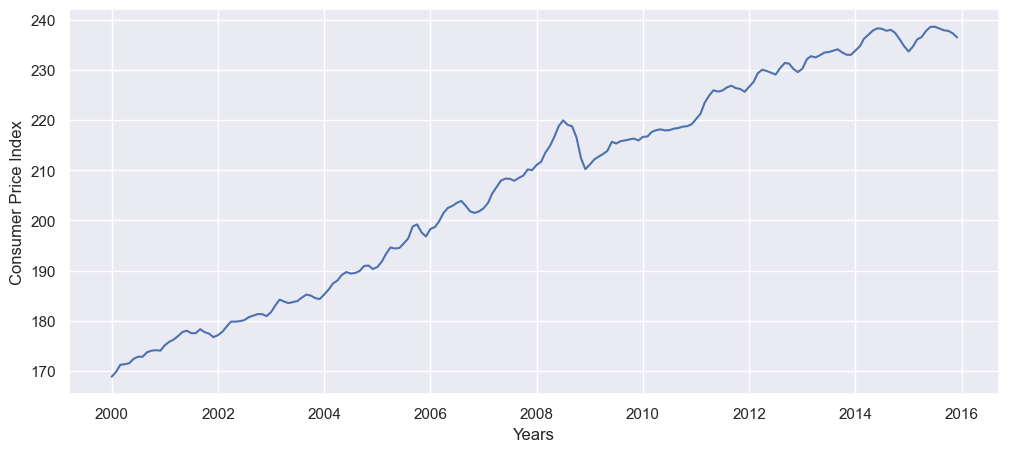

In [7]:
sns.set()

fig,ax = plt.subplots(figsize=(12,5))
ax.plot(df['CPI']) # teh Consumer Price Index
ax.set_xlabel('Years')
ax.set_ylabel('Consumer Price Index')

Text(0, 0.5, '% change in Consumer Price Index')

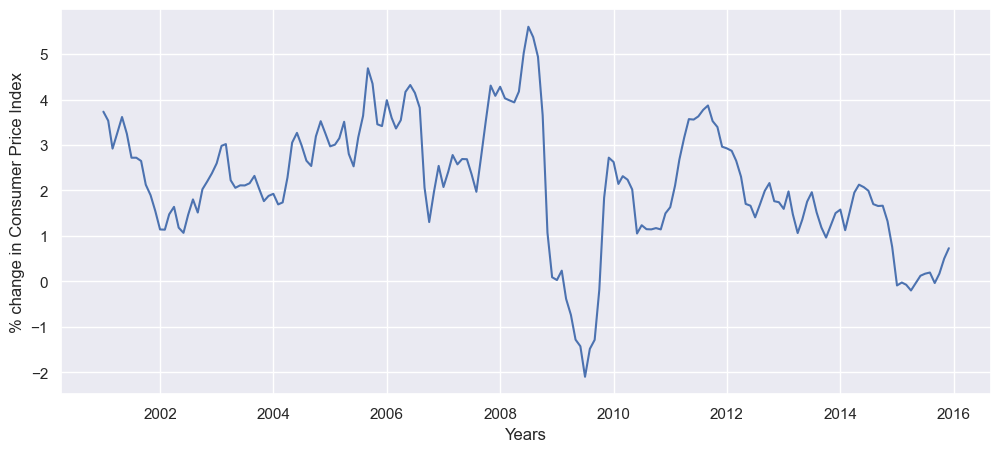

In [5]:
df['pct-change'] =df.CPI.pct_change(periods=12)*100

fig,ax = plt.subplots(figsize=(12,5))
ax.plot(df.index, df['pct-change'])
ax.set_xlabel('Years')
ax.set_ylabel('% change in Consumer Price Index')



A given time series is thought to consist of three systematic components including level, trend, seasonality, and one non-systematic component called noise.

These components are defined as follows:

Level: The average value in the series.
Trend: The increasing or decreasing value in the series.
Seasonality: The repeating short-term cycle in the series.
Noise: The random variation in the series.

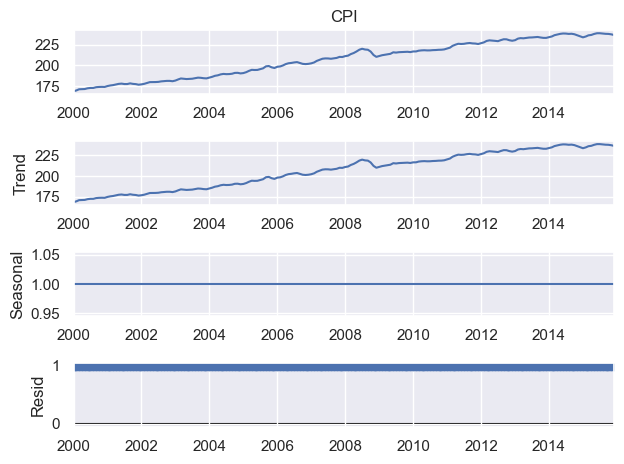

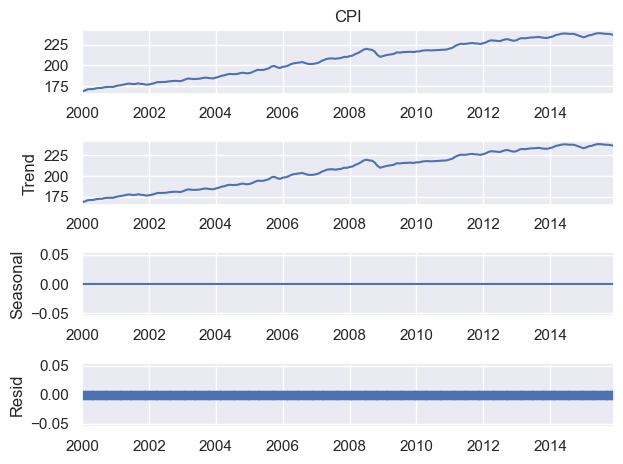

In [6]:
result = seasonal_decompose(df['CPI'], model='multiplicative', period=1)
x = result.plot()
result = seasonal_decompose(df['CPI'], model='additive', period=1)
x = result.plot()

# Statsmodels Auto Reg and ARIMA

In [ ]:
from statsmodels.tsa.ar_model import AutoReg

# Stationarity

In [13]:
from statsmodels.tsa.stattools import adfuller

dftest = adfuller(df['CPI'], autolag = 'AIC')

print('1. ADF : ',dftest[0])
print('2. P-Value : ',dftest[1]) # low p-value means time series is stationary
print('3. Number of Lags : ',dftest[2])
print('4. Number of observations used for ADF Regression and Critical val Creation : ',dftest[3])
print('5. Critical Values : ')
for key, val in dftest[4].items():
  print('\t', key, ": ", val)


1. ADF :  -1.3954362240000378
2. P-Value :  0.5844620838535037
3. Number of Lags :  8
4. Number of observations used for ADF Regression and Critical val Creation :  183
5. Critical Values : 
	 1% :  -3.466598080268425
	 5% :  -2.8774669520682674
	 10% :  -2.5752604356654425


c:\Users\Ramin\AppData\Local\Programs\Python\envs\time_series\Lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


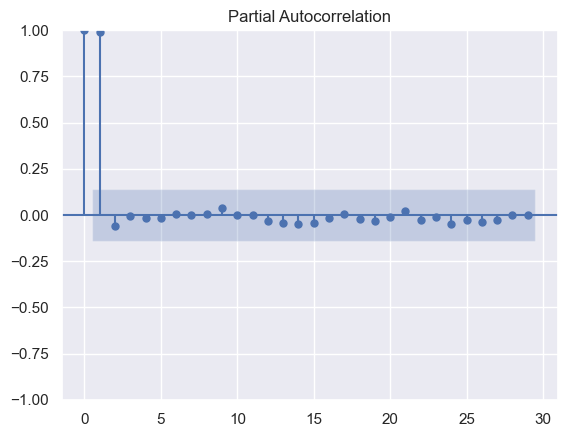

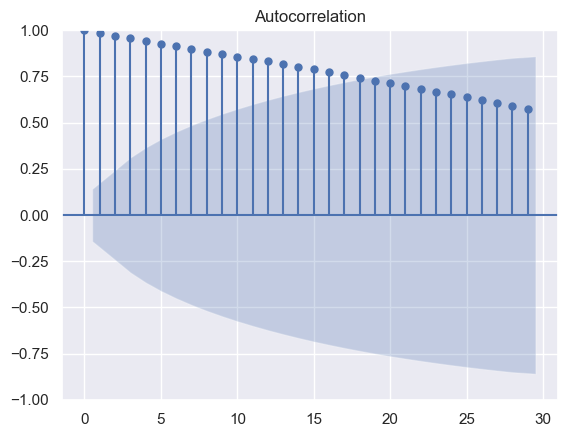

In [15]:
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
pacf = plot_pacf(df['CPI'], lags = 29)
acf = plot_acf(df['CPI'], lags = 29)
# for auto regression we use the PACF, as it only has the direct effects. 

In [16]:
from pmdarima import auto_arima
stepwise_fit = auto_arima(df['CPI'], trace=True,
suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=415.838, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=480.451, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=423.618, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=421.922, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=509.617, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=413.971, Time=0.18 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=413.031, Time=0.10 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=413.720, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=416.851, Time=0.11 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=409.802, Time=0.32 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=411.737, Time=0.33 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=411.776, Time=0.60 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=415.419, Time=0.11 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=413.781, Time=0.36 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=inf, 

# Prophet


In [4]:

from prophet import Prophet


c:\Users\Ramin\AppData\Local\Programs\Python\envs\time_series\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
df2 = df.reset_index()
df2.rename(columns={'date':'ds','CPI':'y'}, inplace=True)
#del df2['pct-change']

In [6]:
df2

,ds,y
0,2000-01-01,168.800
1,2000-02-01,169.800
2,2000-03-01,171.200
3,2000-04-01,171.300
4,2000-05-01,171.500
...,...,...
187,2015-08-01,238.316
188,2015-09-01,237.945
189,2015-10-01,237.838
190,2015-11-01,237.336


In [12]:
m = Prophet()
m.fit(df2)
future = m.make_future_dataframe(periods = 7)


16:21:54 - cmdstanpy - INFO - Chain [1] start processing
16:21:54 - cmdstanpy - INFO - Chain [1] done processing


In [14]:
m

In [15]:
future

,ds
0,2000-01-01
1,2000-02-01
2,2000-03-01
3,2000-04-01
4,2000-05-01
...,...
194,2015-12-04
195,2015-12-05
196,2015-12-06
197,2015-12-07


KeyError: 'trend'

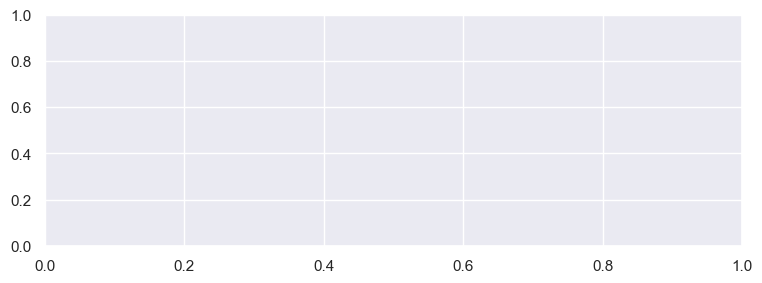

In [22]:
fig2 = m.plot_components(future)